## Importing Modules

In [1]:
import numpy as np 
import os

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [2]:
# setting up to CPU:
tf.config.set_visible_devices(tf.config.list_physical_devices()[0])

In [3]:
## Setting up physical Devices:
physical_devices = tf.config.list_physical_devices('CPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass    

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Defining Constants 

IMG_WIDTH = 224
IMG_HEIGHT = 224
NUM_CHANNELS = 3   # 3 channels - coloured UI screenshots images 
NUM_CLASSES = 2  
BATCH_SIZE = 32
EPOCHS = 10

In [6]:
# (os.path.join('dataset', 'approved-ss'))

# Loading Data:

In [7]:
approved_mobile_path = os.path.join('dataset', 'approved-ss')

In [8]:
other_mobile_path = os.path.join('dataset', 'other-ss')

In [9]:
approved_mobile_list = os.listdir(approved_mobile_path)
other_mobile_list = os.listdir(other_mobile_path)

In [10]:
def load_data(path_to_dir, path_to_dir_list, approved=True):
    label = 1
    if not approved:
        label = 0
    imgs = []
    for file in path_to_dir_list:
        # path = os.path.join(path_to_dir, file)
        img = cv2.imread(os.path.join(path_to_dir, file))
        img = img[:, :-21]
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        # print(len(img))
        imgs.append([img, label])
    return imgs

# load_data(approved_desktop_path, approved_desktop_list, True
            # path to dir         list of imgs file names   labels

In [11]:
approved_mobile_data = load_data(approved_mobile_path, approved_mobile_list, True)
other_mobile_data = load_data(other_mobile_path, other_mobile_list, False)

In [12]:
len(other_mobile_data)


756

In [13]:
len(approved_mobile_data)

749

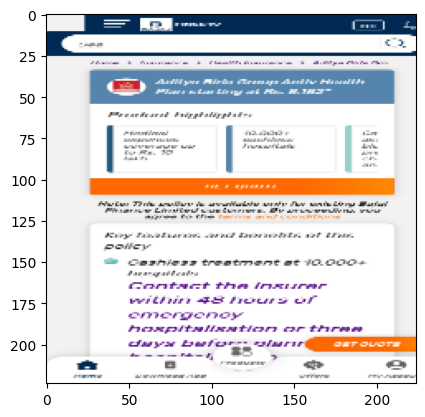

In [14]:
plt.imshow(cv2.cvtColor(other_mobile_data[342][0], cv2.COLOR_RGB2BGR))

## Combining Data, Shuffling both mobile view collected datasets:

In [15]:
combined_mobile_data = approved_mobile_data + other_mobile_data

In [16]:
np.random.seed(30)
np.random.shuffle(combined_mobile_data)

In [17]:
# Converting to Array:
X = []
y = []
for img, label in combined_mobile_data:
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [18]:
X.shape

(1505, 224, 224, 3)

# Image Data Preprocessing:

In [19]:
def preprocess_data(img_data):

    # Normalising to scale: 0-1
    img_data = img_data.astype('float32')
    img_data /= 255.0 

    # More Preprocessing can be done as per the requirements like Greyscaling (to reduce computational cost)
    # here We will keep colored images only (for better accuracy)
    
    return img_data

In [20]:
X = preprocess_data(X)

In [21]:
# X

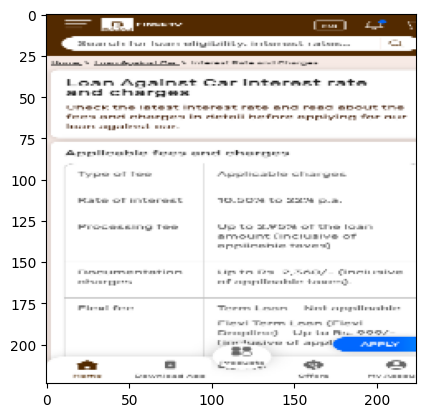

In [22]:
plt.imshow(X[0])


---

# TRAIN-TEST Data Splitting:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

# STYLE CHECK Arhcitecture Building: ðŸ”¨

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
base_model_mobile = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [29]:
x_mobile = base_model_mobile.output
x_mobile = GlobalAveragePooling2D()(x_mobile)

x_mobile = Dense(1024, activation='relu')(x_mobile)

# Add a logistic layer -- we have 1 class
predictions_mobile = Dense(1, activation='sigmoid')(x_mobile)

In [30]:
base_model_mobile.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

---
### Models to be Trained: ðŸ¤›

In [31]:
model_mobile = Model(inputs=base_model_mobile.input, outputs=predictions_mobile)

### Training Only Top layers:

In [32]:
for layer in base_model_mobile.layers:
    layer.trainable = False

In [33]:
# Compiling models and adding Optimizers
model_mobile.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['Accuracy'])

# Check Point Addition:

- **Adding Best weights**

In [34]:
checkpoint_m =  ModelCheckpoint('minor_deviation_detection_soft_max_MOBILE.h5', monitor='val_loss', save_best_only=True)

In [35]:
checkpoint_mobile = ModelCheckpoint('minor_deviation_detection_MOBILE.h5', monitor='val_loss', save_best_only=True)

---

# Training StyleCheck Model Architecture: 

In [36]:
model_mobile.fit(
    X_train, y_train,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_mobile],
    batch_size=BATCH_SIZE
)

Epoch 1/10
33/33 [==============================] - 835s 25s/step - loss: 0.1989 - Accuracy: 0.6876 - val_loss: 0.1527 - val_Accuracy: 0.8451
Epoch 2/10
33/33 [==============================] - 142s 4s/step - loss: 0.1293 - Accuracy: 0.8414 - val_loss: 0.1160 - val_Accuracy: 0.8319
Epoch 3/10
33/33 [==============================] - 156s 5s/step - loss: 0.1098 - Accuracy: 0.8519 - val_loss: 0.1089 - val_Accuracy: 0.8296
Epoch 4/10
33/33 [==============================] - 147s 4s/step - loss: 0.0950 - Accuracy: 0.8813 - val_loss: 0.0817 - val_Accuracy: 0.8982
Epoch 5/10
33/33 [==============================] - 144s 4s/step - loss: 0.0812 - Accuracy: 0.9079 - val_loss: 0.0783 - val_Accuracy: 0.8783
Epoch 6/10
33/33 [==============================] - 147s 4s/step - loss: 0.0781 - Accuracy: 0.9079 - val_loss: 0.0669 - val_Accuracy: 0.9071
Epoch 7/10
33/33 [==============================] - 149s 5s/step - loss: 0.0662 - Accuracy: 0.9231 - val_loss: 0.0638 - val_Accuracy: 0.9226
Epoch 8/10
3

---

# Loading Saved Weights:

In [37]:
model_mobile.load_weights("minor_deviation_detection_MOBILE.h5")

In [38]:
# Final Accuracy and Loss values:

loss_m, accuracy_m = model_mobile.evaluate(X_test, y_test)

15/15 [==============================] - 41s 3s/step - loss: 0.0500 - Accuracy: 0.9358


In [40]:
#model_mobile.load_weights("minor_deviation_detection_soft_max_MOBILE.h5")

In [ ]:
# Final Accuracy and Loss values:

loss_m, accuracy_m = model_mobile.evaluate(X_test, y_test)